In this homework, you need to solve four tasks. The assignment should be uploaded in Jupyter Notebook format(`.ipynb`). Overall, there are 23 points, however, you can get a maximum of 20 points for this assignment( `your_points = min(your_points, 20)`). No bonus points will be transferred to the next assignment.

# Task 1. Non-parametric Density Estimation (6 points)

In [1]:
import numpy as np
import numpy.linalg as nla
import scipy
import scipy.stats
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

from statsmodels.nonparametric.kernel_regression import KernelReg

In [2]:
# Matplotlib settings
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


# non-interactive
%matplotlib inline

#jupyterlab
# %matplotlib widget 

#jupyter-notebook
#%matplotlib notebook 

titlesize = 20
labelsize = 16
legendsize = labelsize
xticksize = 14
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['mathtext.fontset']='cm'
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

You will work with data sampled from the mixture of Normal distributions:

In [3]:
seed1 = 31337
seed2 = 42
n_samples = 100

f1 = scipy.stats.norm(loc=0, scale=1)
f2 = scipy.stats.norm(loc=5, scale=1)
p1 = 0.3
p2 = 1 - p1

Xa = f1.rvs(size=int(p1 * n_samples), random_state=seed1)
Xb = f2.rvs(size=int(p2 * n_samples), random_state=seed2)
samples = np.concatenate([Xa, Xb])

a = -5
b = 10

x_values = np.linspace(a, b, 1000)
binedges = np.linspace(a, b, 10)
true_pdf = p1 * f1.pdf(x_values) + p2 * f2.pdf(x_values)

## Histogram estimate

$\newcommand{\boldX}{\boldsymbol{X}}$
$\newcommand{\xs}[1]{\boldX^{(#1)}}$
$\newcommand{\Sum}{\sum\limits}$
$\newcommand{\Int}{\int\limits}$
$\newcommand{\hatp}{\widehat{p}}$
$\newcommand{\hatJ}{\widehat{J}}$
$\newcommand{\lp}{\left(}$
$\newcommand{\rp}{\right)}$

Given a sample $\boldsymbol{X}^{(n)} = \boldsymbol{X}_1, \boldsymbol{X}_2, ..., \boldsymbol{X}_n \sim \; iid \; p(x)$ we would like to build a hitogram estimate of the density. If we have $m$ bins of size $h$, we can have the following estimates of risk using leave-one-out cross validation:

\begin{gather*}
J(h) = \int \hatp^2\lp x;\xs{n} \rp dx - 2 \int \hatp \lp x;\xs{n} \rp p(x) dx, 
\end{gather*}
\begin{gather*}
\hatJ(h) = \int \hatp^2 \lp x;\xs{n} \rp dx - \frac{2}{n}\Sum_{i = 1}^n \hatp \lp \boldsymbol{X}_i ;\xs{n\backslash i} \rp, \label{eq1}\tag{1}
\end{gather*}
\begin{gather*}
\hatJ(h) = \frac{2}{(n - 1)h} - \frac{n+1}{(n-1)h}\Sum_{i = 1}^m \hatp_j^2,\quad \hatp_j = \frac{n_j}{n}. \label{eq2}\tag{2}
\end{gather*}

Your task is:
1. Build a histogram estimate of the pdf given the sample above, tune bandwidth using leave-one-out CV based on $\hatJ$. Use formula (\ref{eq2}) (1 point)
2. \* Prove that for histograms (\ref{eq2}) follows from (\ref{eq1}) (1 bonus point)
3. Plot CV estimates $\hatJ(h)$ that you obtained during selection. Mark optimal bandwidth $h_{cv}$ and report $h_{cv}$ and $\hatJ(h_{cv})$ (0.5 point)
4. Recall the approximation to $MISE$ from Lecture 8, slide 11. Suppose that an Oracle calculated the integral of the squared derivative of the true density for you and the value is $0.1609848$. What will be the approximate optimal bandwidth $h^*$? Find CV estimate of $J$ for this value of bandwidth and compare it to the one found in part 1 (0.5 point)
5. `np.histogram` has some built-in methods of selecting bandwidth. Compare some of them with your CV result and theoretical approximation (again, using CV estimate of $J$) (1 point)

In [4]:
def cross_validation_histogram(sample, h):
    n = len(sample)
    sample_min, sample_max = np.min(sample), np.max(sample)
    bins = np.int32(np.ceil((sample_max - sample_min) / h))
    h_eff = (sample_max - sample_min) / bins
    mask = np.ones(n, dtype=np.bool_)
    summ = 0
    for i in range(n):
        mask[i] = False
        p = np.histogram(sample[mask], bins=bins, range=(sample_min, sample_max), density=True)[0]
        mask[i] = True
        index = np.int32((sample[i] - sample_min) / h_eff)
        if index > 0 and index < len(p):   
            summ += p[index]
    summ = 2 * summ / n
    
    p = np.histogram(sample, bins=bins, range=(sample_min, sample_max), density=True)[0]
    summ2 = np.sum(p**2) * h
    return summ2 - summ

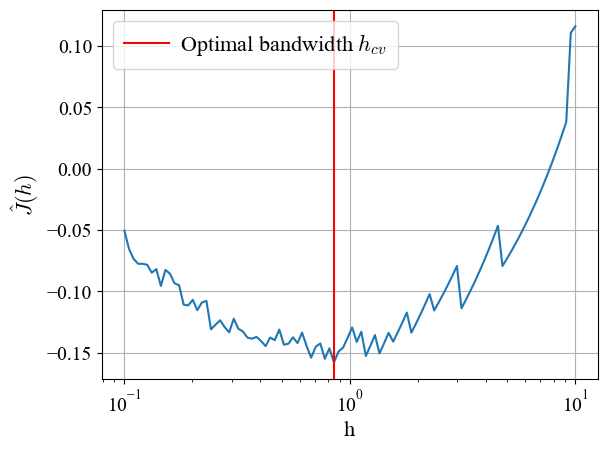

h = 0.8497534359086445, estimated J = -0.15785413585327218


In [5]:
h_list = np.logspace(-1, 1, 100)

cv_hist = [cross_validation_histogram(samples, hi) for hi in h_list]
h_opt = h_list[np.argmin(cv_hist)]

plt.figure()
plt.plot(h_list, cv_hist)
plt.axvline(h_opt, label="Optimal bandwidth $h_{cv}$", color="red")

plt.xscale("log")

plt.xlabel("h")
plt.ylabel("$\hat{J}(h)$")

plt.grid()
plt.legend()
plt.show()

print(f"h = {h_opt}, estimated J = {min(cv_hist)}")

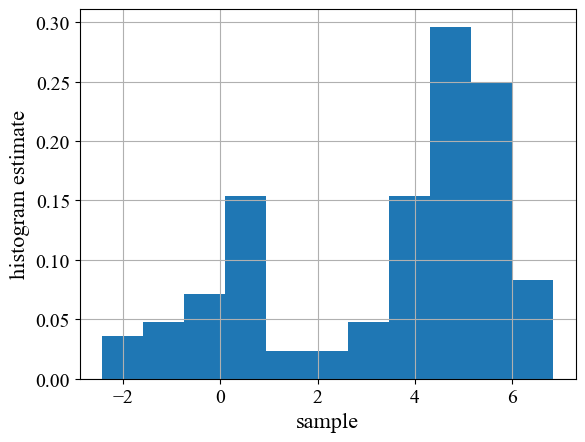

In [6]:
sample_min, sample_max = np.min(samples), np.max(samples)
bins = np.int32(np.ceil((sample_max - sample_min) / h_opt))

plt.hist(samples, bins=bins, density=True)
plt.grid()

plt.xlabel('sample')
plt.ylabel('histogram estimate')
plt.show()

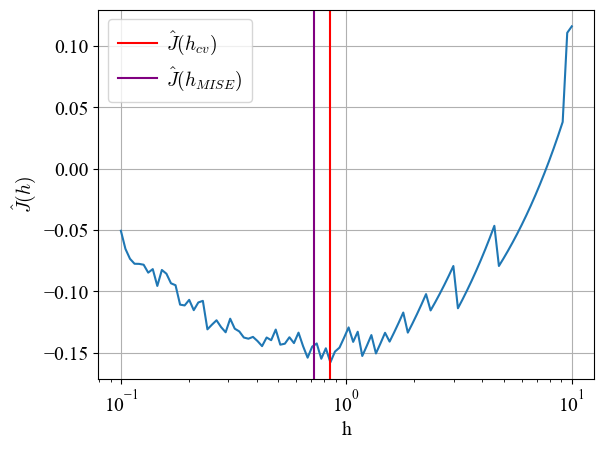

In [7]:
I = 0.1609848
bandwidth_opt = (len(samples) * I / 6) ** (-1/3)
risk_opt = cross_validation_histogram(samples, bandwidth_opt)

plt.plot(h_list, cv_hist)
plt.axvline(h_opt, label="$\hat{J}(h_{cv})$", color="red")
plt.axvline(bandwidth_opt, label="$\hat{J}(h_{MISE})$", color="purple")
plt.xscale("log")

plt.xlabel("h", fontsize=14)
plt.ylabel("$\hat{J}(h)$", fontsize=14)

plt.legend(fontsize=14)
plt.grid()
plt.show()

In [8]:
print(f'cross validation bandwidth:\n{h_opt:.4f}\noptimal bandwidth:\n{bandwidth_opt:.4f}')


cross validation bandwidth:
0.8498
optimal bandwidth:
0.7197


In [9]:
print(f'risk estimate with cross validation bandwidth:\n{min(cv_hist):.4f}')
print(f'risk estimate with optimal bandwidth:\n{risk_opt:.4f}')

risk estimate with cross validation bandwidth:
-0.1579
risk estimate with optimal bandwidth:
-0.1472


As we see, the cross validation bandwidth is larger, than the optimal bandwidth.

## Subtask 5

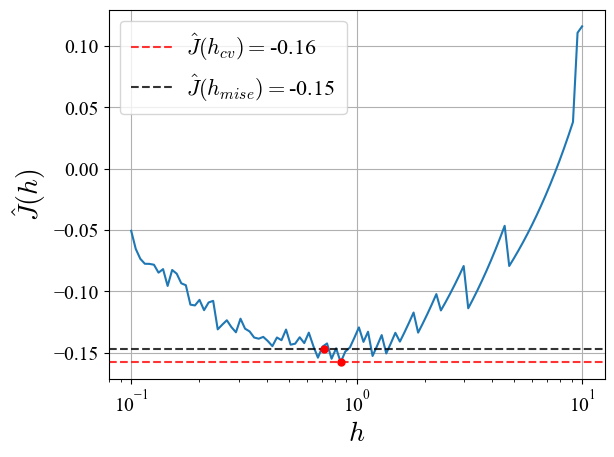

In [10]:
lst = ["auto", "fd","doane","scott","stone","rice","sturges","sqrt"]

base=1e3

for b in lst:
    _, bin_edges = np.histogram(samples, bins=b)
    h_temp = bin_edges[1] - bin_edges[0]
    
    j = cross_validation_histogram(samples, h_temp)
    if j < base:
        h_np = h_temp
    base = min(j, base)


plt.plot(h_list, cv_hist)

plt.axhline(min(cv_hist), c='r', linestyle='--', alpha=0.8, label=r'$\hat{J}(h_{cv})=$'f'{min(cv_hist):.2f}')

plt.axhline(risk_opt, c='k', linestyle='--', alpha=0.8, label=r'$\hat{J}(h_{mise})=$'f'{risk_opt:.2f}')

plt.plot(bandwidth_opt, risk_opt, 'ro', markersize='5')
plt.plot(h_opt, min(cv_hist), 'ro', markersize='5')

plt.xscale("log")
plt.xlabel(r'$h$', fontsize=20)
plt.ylabel(r'$\hat{J}(h)$', fontsize=20)

plt.grid()
plt.legend()
plt.show()

## Kernel density estimate

In this part, you will use the same sample, but employ the kernel density estimation method. We can use the same proxy expression to optimise the risk:
\begin{gather*}
J(h) = \int \hatp^2 \lp x;\xs{n} \rp dx - 2 \int \hatp \lp x;\xs{n} \rp p(x) dx
\end{gather*}

In out case of kernel estimator, we can obtain:
\begin{gather*}
\hatJ(h) = \frac{1}{hn^2}\Sum_{i = 1}^n\Sum_{j = 1}^n K^{(2)}\lp\frac{x_i - x_j}{h}\rp + \frac{2K(0)}{nh}, \label{eq3}\tag{3}
\end{gather*}
where
\begin{gather*}
K^{(2)}(x) = K^*(x) - 2K(x), \quad K^*(x) = \int K(x - y) K(y) dy.
\end{gather*}

You can use [kernel density estimation from sklearn](http://scikit-learn.org/stable/modules/density.html). Your task is:
1. Build a kernel density estimate given the sample from before, tune bandwidth using leave-one-out CV. Try two different kernels of your choice. Use formula \ref{eq3} in your tuning procedure (1 point)
2. Plot CV estimates $\hatJ(h)$ that you obtained during selection. Mark optimal bandwidth $h_{cv}$ and report $h_{cv}$ and $\hatJ(h_{cv})$. What kernel worked better in terms of estimated surrogate risk? (0.5 point)
3. Recall the approximation to $MISE$ from Lecture 8, slide 20. Suppose that an Oracle calculated the integral of the squared second derivative of the true density for you and the value is $0.127529$. What will be the approximate optimal bandwidth $h^*$? Find CV estimate of $J$ for this value of bandwidth and compare it to the one found in part 1 (0.5 point)

In [11]:
# Your code here


# Task 2. Non-parametric Regression (5.5 pt)

In this task you will apply non-parametric regression to airport statistics data.

### Data loading and preprocessing

Load dataset from `airport_operations_report.csv`. Use `General Aviation: Total Operations` as target (dependent) variable and `[Air Carrier Operations, General Aviation: Local Operations]` as covariates(independent variables). Divide $1^{st}$ covariate by `1000`, $2^{nd}$ by `100` and target by `1000`. Make a 2D grid for covariates from minimum to maximum values with `100` steps along each dimension.

In [12]:
# Your code

df = pd.read_csv('airport_operations_report.csv')
df["Air Carrier Operations"] /= 1000
df["General Aviation: Local Operations"] /= 100
df["General Aviation: Total Operations"] /= 1000
df

,Air Carrier Operations,General Aviation: Local Operations,General Aviation: Total Operations
0,10.329,0.04,2.219
1,10.593,0.28,3.312
2,11.320,0.56,3.310
3,11.936,0.00,3.382
4,11.726,2.56,4.242
...,...,...,...
112,8.307,2.04,4.210
113,7.976,2.27,4.503
114,7.806,2.82,5.135
115,7.591,2.38,4.902


In [13]:
car_op = np.linspace(df['Air Carrier Operations'].min(), df['Air Carrier Operations'].max(), num=100)
loc_op = np.linspace(df['General Aviation: Local Operations'].min(), df['General Aviation: Local Operations'].max(), num=100)

grid = []

for i in car_op:
    for j in loc_op:
        grid.append([i, j])

grid = np.array(grid)
grid

array([[ 7.591     ,  0.        ],
       [ 7.591     ,  0.05323232],
       [ 7.591     ,  0.10646465],
       ...,
       [12.884     ,  5.16353535],
       [12.884     ,  5.21676768],
       [12.884     ,  5.27      ]])

In [14]:
sample = df[["Air Carrier Operations", "General Aviation: Local Operations"]].copy()
target = df["General Aviation: Total Operations"].copy()

### Fit model (1 pt)

Perform a nonparametric regression to fit the model $Y = f(x)+\varepsilon$.

Predict values for the created grid.

In [15]:
# step_numbers - number of steps in grid: (100, 100)

# Your code
step_numbers = (100, 100)
reg = KernelReg(target, sample, var_type='cc', reg_type='lc')

target_pred = reg.fit(grid)[0]

target_pred = target_pred.reshape(*step_numbers)
grid = np.array(grid).reshape(*step_numbers, 2)

This is function to visualize 3D surfaces. You can modify it if you need.

In [16]:
def plot_surface_function(x1, x2, y, minmax_values=None, ax=None):
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(projection="3d")


        surf = ax.plot_surface(x1, x2, y, cmap=cm.rainbow, linewidth=0.5, alpha=0.5, edgecolor="k")
        if minmax_values is not None:
            ax.set_xlim3d(*minmax_values[0])
            ax.set_ylim3d(*minmax_values[1])
    
    else:
        surf = ax.plot_surface(x1, x2, y, cmap=cm.bwr, linewidth=0.5, alpha=0.1, edgecolor="k")
        
    return ax

Let's plot the estimated surface.

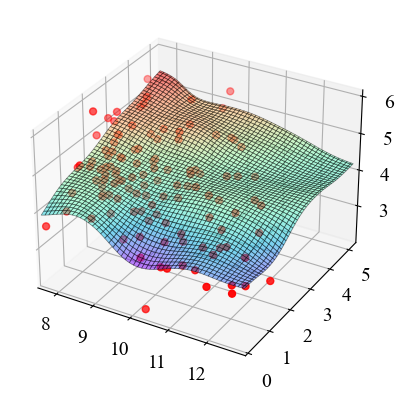

In [17]:
# target - dependent variable
# grid - grid for covariates
# sample - covariates

car_mm = []
car_mm.append(grid[0][0][0])
car_mm.append(grid[-1][-1][0])

loc_mm = []
loc_mm.append(grid[0][0][1])
loc_mm.append(grid[-1][-1][1])


ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred, minmax_values=np.vstack((car_mm, loc_mm)))
ax.scatter(sample.values[:, 0], sample.values[:, 1], target, marker="o", s=25, c="r")

### Estimate confidence intervals (2 pt)

Construct 95\% confidence bands for your estimate. To estimate error variance for 1D covariate, you sort your sample and subtract target values of the nearest points. For 2D covariate, you should, for each point, calculate the difference in target values between a point and its nearest neighbor (in euclidian metric). 

To get power for quantile of the standard normal distribution, which is $\frac{h}{b-a}$ for 1D, estimate it per coordinate and multiply: $\prod_{i=1}^2 \frac{h_i}{b_i-a_i}$. 

For gaussian kernal $h = 3 \times$ kernel_bandwidth.

In [18]:
from sklearn.metrics.pairwise import rbf_kernel
import scipy.stats as sps

In [19]:
def prediction_se(grid, sample, target, h, kernel_reg, alpha=0.05):

    n = target.shape[0]
    sigma_est = 0.
    
    mask = np.ones(n, dtype=int)
    
    for s_id, samp in enumerate(sample):
        
        mask[s_id] = False
        min_dist = np.inf
        min_ngb = None

        for ngb in sample[mask]:

            dist = nla.norm(samp - ngb)
            if dist < min_dist:
                min_dist = min(min_dist, dist)
                min_ngb = ngb
                
        mask[s_id] = True
        
        sigma_est += (kernel_reg.fit(samp)[0] - kernel_reg.fit(min_ngb)[0]) ** 2 
        
    sigma_est /= (2 * (n-1))
    
    delta_1 = np.max(sample[:, 0]) - np.min(sample[:, 0])
    delta_2 = np.max(sample[:, 1]) - np.min(sample[:, 1])
    
    kernel_values = 1 / np.sqrt(2 * np.pi) * rbf_kernel(grid / h, sample / h, 0.5)
    kernel_sum = np.sum(kernel_values, axis=1, keepdims=True)

    nonzero_indices = kernel_sum[:, 0] > 1e-8
    kernel_weights = kernel_values
    kernel_weights[nonzero_indices] = kernel_weights[nonzero_indices] / kernel_sum[nonzero_indices]
    kernel_weights[~nonzero_indices] = 0

    se = np.sqrt(np.sum(kernel_weights**2, axis=1) * sigma_est)
    m1, m2 = delta_1 / (3.0 * h[0]), delta_2 / (3.0 * h[1])
    q = sps.norm.ppf((1+(1-alpha)**(1.0/(m1 * m2)))/2)
    return q * se

In [20]:
a = prediction_se(grid.reshape((10000, 2)), sample.values, target,reg.bw, reg,alpha=0.05).reshape((100, 100))
a = a.reshape(*step_numbers)
a.shape

(100, 100)

Let's plot confidence intervals

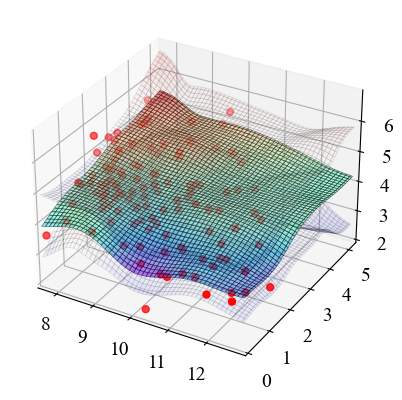

In [21]:
ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred, minmax_values=np.vstack((car_mm, loc_mm)))
ax.scatter(sample.values[:, 0], sample.values[:, 1], target, marker="o", s=25, c="r")
ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred + a, ax=ax)
ax = plot_surface_function(grid[:, :, 0], grid[:, :, 1], target_pred - a, ax=ax)

### Find optimal bandwidth (2 pt)

Use cross-validation to estimate the bandwidth.

In [22]:
# Your code here

def cross_validation_regression(sample, target, h):
    n = sample.shape[0]
    
    kernel_values = 1 / np.sqrt(2 * np.pi) * rbf_kernel(sample / h, sample / h, 0.5)
    kernel_norm = np.sum(kernel_values, axis=1) + 1e-8
    
    regression = KernelReg(target, sample, var_type='cc', reg_type='lc', bw=h)
    kernel_at_zero = 1 / np.sqrt(2 * np.pi)

    risk_estimate = np.sum((target - regression.fit(sample)[0]) ** 2 / (1 - kernel_at_zero / kernel_norm) ** 2)
    return risk_estimate

Make a grid with logarithmic scale to find best bandwidth, from `0.1` to `10` with `21` steps along each dimension. Visualize the obtained results with `plot_surface_function`. Print values of optimal bandwidth.

In [23]:
bandwidth_space_x = np.exp(np.linspace(np.log(0.1), np.log(10), 21))
bandwidth_space_y = bandwidth_space_x.copy()

bandwidth_space = np.meshgrid(bandwidth_space_x, bandwidth_space_y)
bandwidth_pairs = np.vstack([bandwidth_space[0].ravel(), bandwidth_space[1].ravel()]).T

In [24]:
cv_space = np.array([cross_validation_regression(sample.values, target, bandwidth_pair) for bandwidth_pair in bandwidth_pairs]).reshape(21, 21)

Plot surface with estimated bandwidth.

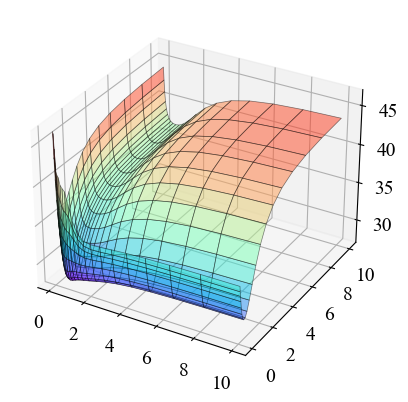

In [25]:
# Your code here

bandwidth_area = np.empty((21, 21, 2))
bandwidth_area[:, :, 0] = bandwidth_space[0]
bandwidth_area[:, :, 1] = bandwidth_space[1]

ax = plot_surface_function(bandwidth_area[:, :, 0], bandwidth_area[:, :, 1], cv_space)
plt.show()

In [26]:
bandwidth_opt = bandwidth_pairs[np.nanargmin(cv_space)]
print(f'optimal bandwidth:\n{bandwidth_opt}')

optimal bandwidth:
[0.50118723 0.50118723]


### Conclusion (0.5 pt)

Write your conclusions about conducted experiments (2-5 sentence).



The points are spread widely. It seems like the closer a value from a test to the origianl data, the higher probability, that the prediction about it is right.

# Task 3. Model Selection (5.5 pt)

In this task you will select a model (choose a set of covariates) using AIC criteria and forward/backward stepwise regression.

### Data loading and preprocessing

Read dataset `pacn_wrcc.csv`. The target variable is `ly Solar Rad.`, others are covariates.

In [27]:
# Your code

new_df =  pd.read_csv('pacn_wrcc.csv')
new_target = new_df["ly Solar Rad."]
new_df = new_df.drop("ly Solar Rad.", axis=1)
new_df

,mph Wind Speed,Deg Wind Direc,Deg F Av Air Temp,% Rel Humidty,volts Battery Voltage,Deg Dir MxGust,mph Mx Gust Speed,Deg F Mn Air Temp,Deg F Mx Air Temp,"Deg F 2"" Soil Ave Tmp","Deg F 4"" Soil Ave Tmp","Deg F 8"" Soil Av Temp","Deg F 20""Soil Av Temp"
0,4.428,49.350,59.96,88.2,12.52,85.0,16.240,59.37,60.33,64.28,61.68,61.85,61.37
1,4.347,30.130,59.33,91.2,12.33,40.0,16.370,58.52,59.73,63.61,61.77,61.65,61.25
2,4.592,35.970,58.60,89.7,12.26,163.0,21.540,58.34,58.84,62.90,61.80,61.57,61.20
3,4.264,19.190,58.33,88.9,12.24,35.0,17.340,58.05,58.72,62.36,61.74,61.47,61.14
4,3.755,8.620,58.19,89.6,12.22,164.0,16.890,57.87,58.53,61.79,61.72,61.47,61.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,4.731,0.020,58.32,77.4,12.57,42.0,11.230,57.76,58.79,61.63,63.74,63.31,61.92
296,4.421,1.703,56.72,87.2,12.55,37.0,7.852,55.03,58.19,60.91,63.40,63.20,61.91
297,4.501,357.500,55.36,85.7,12.53,313.0,7.404,54.42,56.00,60.44,63.12,63.14,61.95
298,3.910,358.300,55.64,88.0,12.51,357.0,7.606,54.66,56.49,60.14,62.89,63.12,62.06


In [28]:
new_target

0      5.748000
1      0.218700
2      0.007225
3      0.009203
4      0.006709
         ...   
295    0.001634
296    0.003612
297    0.001462
298    0.000774
299    0.000516
Name: ly Solar Rad., Length: 300, dtype: float64

Scale covariates to range `[0, 1]` and add bias column.

In [29]:
normalized_df=(new_df-new_df.min())/(new_df.max()-new_df.min())
normalized_df

,mph Wind Speed,Deg Wind Direc,Deg F Av Air Temp,% Rel Humidty,volts Battery Voltage,Deg Dir MxGust,mph Mx Gust Speed,Deg F Mn Air Temp,Deg F Mx Air Temp,"Deg F 2"" Soil Ave Tmp","Deg F 4"" Soil Ave Tmp","Deg F 8"" Soil Av Temp","Deg F 20""Soil Av Temp"
0,0.385036,0.137073,0.452415,0.709667,0.289256,0.232493,0.455965,0.492595,0.414765,0.567308,0.392435,0.485915,0.430556
1,0.372742,0.083667,0.407670,0.808644,0.132231,0.106443,0.461701,0.426345,0.374497,0.513622,0.413712,0.415493,0.347222
2,0.409926,0.099894,0.355824,0.759155,0.074380,0.450980,0.689816,0.412315,0.314765,0.456731,0.420804,0.387324,0.312500
3,0.360146,0.053268,0.336648,0.732761,0.057851,0.092437,0.504501,0.389712,0.306711,0.413462,0.406619,0.352113,0.270833
4,0.282896,0.023897,0.326705,0.755856,0.041322,0.453782,0.484645,0.375682,0.293960,0.367788,0.401891,0.352113,0.256944
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.431021,0.000000,0.335937,0.353349,0.330579,0.112045,0.234910,0.367108,0.311409,0.354968,0.879433,1.000000,0.812500
296,0.383973,0.004677,0.222301,0.676674,0.314050,0.098039,0.085863,0.154326,0.271141,0.297276,0.799054,0.961268,0.805556
297,0.396115,0.993331,0.125710,0.627186,0.297521,0.871148,0.066096,0.106781,0.124161,0.259615,0.732861,0.940141,0.833333
298,0.306420,0.995554,0.145597,0.703068,0.280992,0.994398,0.075009,0.125487,0.157047,0.235577,0.678487,0.933099,0.909722


### $C_p$ Mallow and sample variance (2 pt) 

Estimate sample variance of error with full set of covariates. Take into account number of dependent variables.

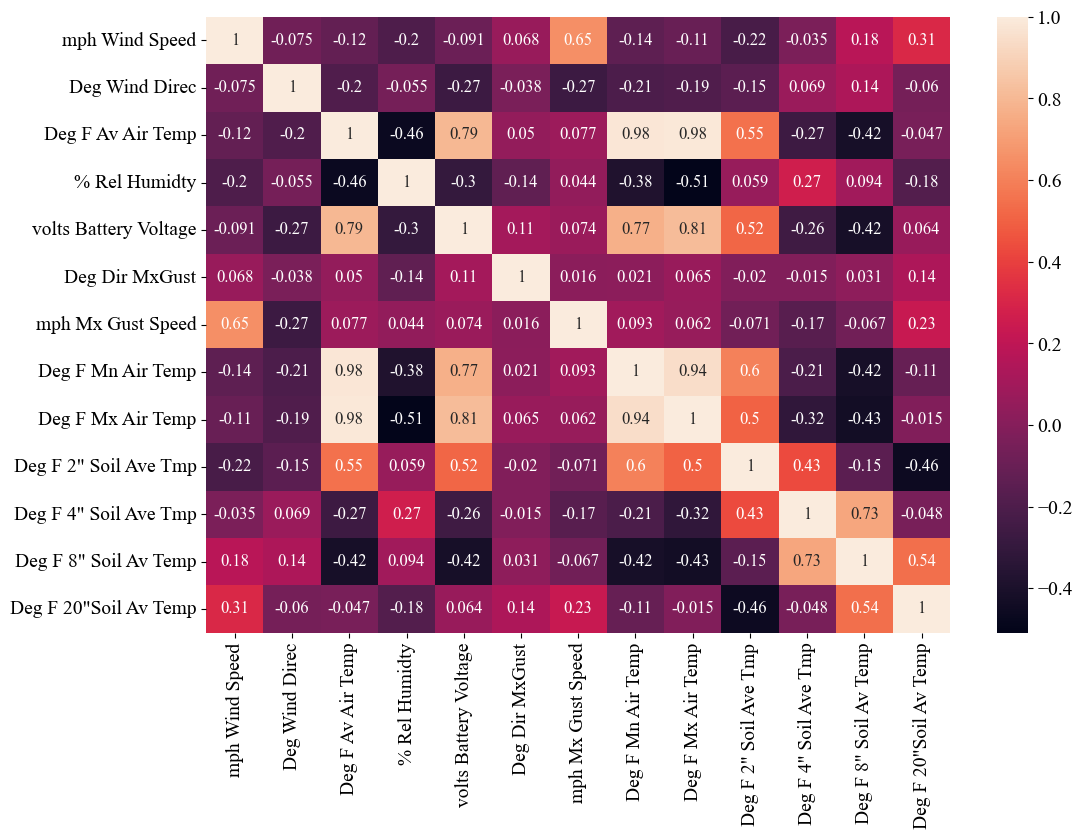

In [30]:
# Your code
plt.figure(figsize=(12, 8))

sns.heatmap(normalized_df.corr(), annot=True)

plt.show()

In [31]:
new_reg = LinearRegression(fit_intercept=False)
new_reg.fit(normalized_df.values, new_target)

prediction = new_reg.predict(normalized_df.values)

est_var = np.var(new_target - prediction)
est_var

27.265965588814208

Implement estimation of $C_p$ Mallow for given covariates, target and error variance.

In [32]:
def cp(df, target, s):

    reg = LinearRegression(fit_intercept=False)
    reg.fit(df, target)

    prediction = reg.predict(df)

    risk_tr = np.sum((target - prediction) ** 2)
    comp = 2 * len(df.columns) * s

    return risk_tr + comp

cp(normalized_df, new_target, est_var)

8888.930077301156

### Forward stepwise regression (1 pt)

Implement forward stepwise regression. Save the order in which covariates are added to feature set and $C_p$ values for those feature sets.

In [33]:
def forward_stepwise_regression(df, target, est_var):
    
    # Your code
    
    covariates = []
    cov_lst = list(df.columns)

    score = np.inf
    statistics_lst = []

    for i in range(len(df.columns)):
        curr_cov = None
        
        for cov in cov_lst:
            x_subspace = df[covariates + [cov]]
            cp_statistic = cp(x_subspace, target, est_var)
            
            if cp_statistic < score:
                score = cp_statistic
                curr_cov = cov

        if curr_cov == None:
            break

        covariates.append(curr_cov)
        statistics_lst.append(score)
        cov_lst.remove(curr_cov)
        
    return covariates, statistics_lst

In [34]:
features, cp_list = forward_stepwise_regression(normalized_df, new_target, est_var)
for a, cp_value in enumerate(cp_list, 1):
    print(f"Cp = {cp_value:.3f} after appending covariates from the following list\n{features[:a]}\n")

Cp = 35188.076 after appending covariates from the following list
['Deg F Mx Air Temp']

Cp = 17091.170 after appending covariates from the following list
['Deg F Mx Air Temp', '% Rel Humidty']

Cp = 13822.302 after appending covariates from the following list
['Deg F Mx Air Temp', '% Rel Humidty', 'volts Battery Voltage']

Cp = 11569.644 after appending covariates from the following list
['Deg F Mx Air Temp', '% Rel Humidty', 'volts Battery Voltage', 'mph Mx Gust Speed']

Cp = 10139.336 after appending covariates from the following list
['Deg F Mx Air Temp', '% Rel Humidty', 'volts Battery Voltage', 'mph Mx Gust Speed', 'Deg F 4" Soil Ave Tmp']

Cp = 9628.186 after appending covariates from the following list
['Deg F Mx Air Temp', '% Rel Humidty', 'volts Battery Voltage', 'mph Mx Gust Speed', 'Deg F 4" Soil Ave Tmp', 'Deg F Av Air Temp']

Cp = 8999.343 after appending covariates from the following list
['Deg F Mx Air Temp', '% Rel Humidty', 'volts Battery Voltage', 'mph Mx Gust Speed'

### Backward stepwise regression (1 pt)

Implement backward stepwise regression. Save the order in which covariates are removed from feature set and $C_p$ values for those feature sets.

In [35]:
def backward_stepwise_regression(df, target, est_var):
    
    # Your code
    
    covariates = []
    cov_lst = list(df.columns)

    statistics_lst = []
    score = cp(df, target, est_var)

    for i in range(len(df.columns)):
        covariate_last = None
        
        for covariate in cov_lst:
            x_subspace = df[[c for c in cov_lst if c != covariate]]
            cp_statistic = cp(x_subspace, target, est_var)
            
            if cp_statistic < score:
                score = cp_statistic
                covariate_last = covariate

        if covariate_last == None:
            break

        covariates.append(covariate_last)
        statistics_lst.append(score)
        cov_lst.remove(covariate_last)
        
    return covariates, statistics_lst

In [36]:
features, cp_list = backward_stepwise_regression(normalized_df, new_target, est_var)
for a, cp_value in enumerate(cp_list, 1):
    print(f"C_p {cp_value:.3f} +{features[:a]}")

C_p 8842.235 +['Deg F 8" Soil Av Temp']
C_p 8795.695 +['Deg F 8" Soil Av Temp', 'mph Wind Speed']
C_p 8751.564 +['Deg F 8" Soil Av Temp', 'mph Wind Speed', 'Deg Dir MxGust']


### Bruteforce (1 pt)

Find best sets of covariates and their $C_p$ for all sizes of feature sets.

In [37]:
def bruteforce(df, target, est_var):
    
    # Your code
    
    min_risk = cp(df, target, est_var)
    
    features = np.array([x for x in range(df.shape[1])], dtype=int)
    
    best_features = [[] for x in range(df.shape[1])]
    
    cp_list = np.repeat(1e8, df.shape[1])
    
    for i in range(1, 2**df.shape[1]):
    
        num = bin(i)
        
        mask = np.array([d == '1' for d in num[2:].zfill(df.shape[1])], dtype=bool)
        
        risk = cp(df.iloc[:, features[mask]], target, est_var)
        
        old_min = cp_list[num.count('1') - 1]
        
        if risk < old_min:
            cp_list[num.count('1') - 1] = min(cp_list[num.count('1') - 1], risk)
            best_features[num.count('1') - 1] = features[mask]
    
    return best_features, cp_list

In [38]:
features, cp_list = bruteforce(normalized_df, new_target, est_var)
for a, cp_value in enumerate(cp_list):
    print(f"C_p {cp_value:.3f} -{features[a]}")

C_p 35188.076 -[8]
C_p 17091.170 -[3 8]
C_p 13584.243 -[2 3 4]
C_p 11419.482 -[2 3 4 6]
C_p 9573.699 -[ 2  3  4  6 10]
C_p 9221.060 -[ 2  3  4  6  7 10]
C_p 8999.343 -[ 2  3  4  6  7  8 10]
C_p 8967.783 -[ 1  2  3  4  6  7  8 10]
C_p 8799.662 -[ 2  3  4  6  7  8  9 10 12]
C_p 8751.564 -[ 1  2  3  4  6  7  8  9 10 12]
C_p 8795.695 -[ 1  2  3  4  5  6  7  8  9 10 12]
C_p 8842.235 -[ 0  1  2  3  4  5  6  7  8  9 10 12]
C_p 8888.930 -[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


### Conclusion (0.5 pt)

Write your conclusions about conducted experiments (2-5 sentence).

All three approaches work well for that task, howeher, in case of having a bigger problem, it would be difficult to conduct the bruteforce algorithm because of the complexity of computing. So I suppose, that the best choice is using the forward and the backward ones.

# Task 4. Local regression (6 points)

In [39]:
from statsmodels.nonparametric.kernel_regression import KernelReg
from sklearn.linear_model import LogisticRegression

In [40]:
X = np.array([-3.        , -2.93939394, -2.87878788, -2.81818182, -2.75757576,
       -2.6969697 , -2.63636364, -2.57575758, -2.51515152, -2.45454545,
       -2.39393939, -2.33333333, -2.27272727, -2.21212121, -2.15151515,
       -2.09090909, -2.03030303, -1.96969697, -1.90909091, -1.84848485,
       -1.78787879, -1.72727273, -1.66666667, -1.60606061, -1.54545455,
       -1.48484848, -1.42424242, -1.36363636, -1.3030303 , -1.24242424,
       -1.18181818, -1.12121212, -1.06060606, -1.        , -0.93939394,
       -0.87878788, -0.81818182, -0.75757576, -0.6969697 , -0.63636364,
       -0.57575758, -0.51515152, -0.45454545, -0.39393939, -0.33333333,
       -0.27272727, -0.21212121, -0.15151515, -0.09090909, -0.03030303,
        0.03030303,  0.09090909,  0.15151515,  0.21212121,  0.27272727,
        0.33333333,  0.39393939,  0.45454545,  0.51515152,  0.57575758,
        0.63636364,  0.6969697 ,  0.75757576,  0.81818182,  0.87878788,
        0.93939394,  1.        ,  1.06060606,  1.12121212,  1.18181818,
        1.24242424,  1.3030303 ,  1.36363636,  1.42424242,  1.48484848,
        1.54545455,  1.60606061,  1.66666667,  1.72727273,  1.78787879,
        1.84848485,  1.90909091,  1.96969697,  2.03030303,  2.09090909,
        2.15151515,  2.21212121,  2.27272727,  2.33333333,  2.39393939,
        2.45454545,  2.51515152,  2.57575758,  2.63636364,  2.6969697 ,
        2.75757576,  2.81818182,  2.87878788,  2.93939394,  3.        ])

In [41]:
Y = np.array([1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

You are given a sample of pairs $(X_i, Y_i)$. The output variable appers to be binary. We know a model for this type of data: logistic regression. In this model we assume the log-odds of the Bernoulli output variable to be a linear function:
$$\mathbb{P}(Y_i = 1 | X_i = x_i) = p(x_i) = \frac{e^{\beta_0 + \beta_1 x_i}}{1 + e^{\beta_0 + \beta_1 x_i}}$$
Lets fit a standard logistic regression to the data:

In [42]:
logreg = LogisticRegression(penalty='none')
logreg.fit(X.reshape(-1, 1), Y)
p_pred_global = logreg.predict_proba(X.reshape(-1, 1))[:, 1]
print(f"Coefficients of the fitted logistic regression model: b0={logreg.intercept_[0]}, b1={logreg.coef_[0][0]}")

Coefficients of the fitted logistic regression model: b0=0.3769839468432626, b1=0.9109286874944


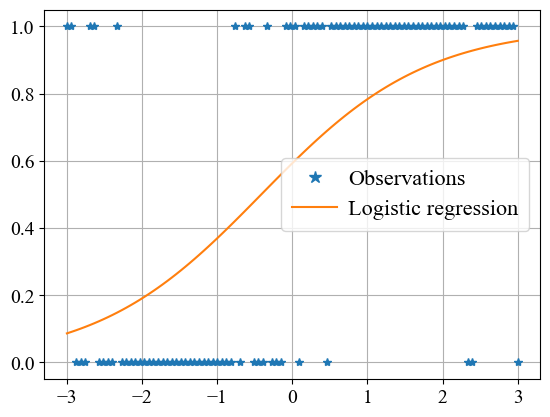

In [43]:
plt.plot(X, Y, '*', label='Observations')
plt.plot(X, p_pred_global, label='Logistic regression')
plt.grid()
plt.legend()

## Local regression

As we can see, the dependence of the outcome on $x$ looks more complex than estimated using logistic regression. We will try to improve it with local regression methods.
Instead of a global model, we will approximate conditinal probability of the positive class in a neighbourhood of $x$ with:
$$p(u) \approx \frac{e^{\beta_0 + \beta_1 (u-x) }}{1 + e^{\beta_0 + \beta_1 (u-x)}}, $$
for $u$ close to $x$. The coefficients in this case will depend on $x$. To find them, we will have to fit a (slightly different) model **at each new query point** $x_{new}$ (point where we want to predict $Y$). We will also need to introduce a notion of 'closeness' of points across $x$ - for this we can use our familiar *kernel functions*. Bringing everything together, we introduce the following **local** loglikelihood for our proposed model:
$$\ell_x(\beta) = \sum\limits_{i=1}^{n} K\left(\frac{x-X_i}{h}\right)\ell\left(Y_i, \beta_0 + \beta_1 \left(X_i - x\right)\right) = \sum\limits_{i=1}^{n} K\left(\frac{x-X_i}{h}\right) \left(Y_i \left(\beta_0 + \beta_1 \left(X_i - x\right)\right) - \log \left( 1 + e^{\beta_0 + \beta_1 \left(X_i - x\right)} \right) \right),$$
$$\ell(y, z) = yz - \log \left(1 + e^z \right).$$
Here $\ell(y, z)$ is a log-likelohood for a single Bernoulli with log-dds ratio $z = \log\frac{p}{1-p}$. The local log-likelihood $\ell_x(\beta)$ should be optimized numerically for each new point $x$ to obtain $\widehat{\beta}(x)=(\widehat{\beta_0}(x), \widehat{\beta_1}(x))$. Then, we can predict $Y$ using the logistic model:
$$ \mathbb{P}(Y=1 | X=x) = \frac{e^{\beta_0(x)}}{1 + e^{\beta_0(x)}}.$$
Your task is:
1. Implement the proposed local logistic regression approach using Gaussian kernel. *Hint*: look at additional parameters of the `fit` method of [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) from `sklearn` package (2 points)
2. Select optimal bandwidth using leave-one-out log-likelihood cross-validation with log-likelihood as metric: $\ell_{cv} = \sum_i \ell(Y_i, \widehat{z}_{-i}(x_i))$, where $\widehat{z}_{-i}$ is the estimated log-odds ratio without $i$th sample (3 points)
3. Now ignore that the output variable is binary. Compare previous results with local linear kernel regression method using `KernelReg` from `statsmodels`. Use leave-one out squared error cross-validation to select the bandwidth (1 bonus point)

In [44]:
class LocalLogisticRegression():
    def __init__(self, bandwidth=1):
        self.bandwidth = bandwidth
    
    def fit(self, x, y):
        self.x_sample = x
        self.y_sample = y

    def predict_proba(self, x):
        z = self.x_sample - x
        weights = 1 / np.sqrt(2 * np.pi) * np.exp(-z.reshape(-1) ** 2 / (2 * self.bandwidth))

        logreg = LogisticRegression()

        logreg.fit(z.reshape(-1, 1), self.y_sample, weights)

        return 1 / (1 + np.exp(-logreg.intercept_))
    
    def predict(self, x):
        return int(self.predict_proba(x) > 0.5)

In [45]:
def cross_validation_local_logreg(x, y, bandwidth):
    scores = np.zeros(len(x))

    for i in range(len(x)):
        x_in, x_out = np.delete(x, i, axis=0), x[i]
        y_in, y_out = np.delete(y, i, axis=0), y[i]

        local_logreg = LocalLogisticRegression(bandwidth=bandwidth)

        local_logreg.fit(x_in, y_in)
        prob_out = local_logreg.predict_proba(x_out)

        log_likelihood = y_out * np.log(prob_out) + (1 - y_out) * np.log(1 - prob_out)
        scores[i] = log_likelihood
    
    return np.sum(scores)

In [46]:
bandwidth_space = np.logspace(-2, 1, num=100, base=10)
cv_space = np.array([cross_validation_local_logreg(X, Y, bandwidth) for bandwidth in bandwidth_space])

bandwidth_opt = bandwidth_space[np.argmax(cv_space)]
bandwidth_opt

0.16297508346206444

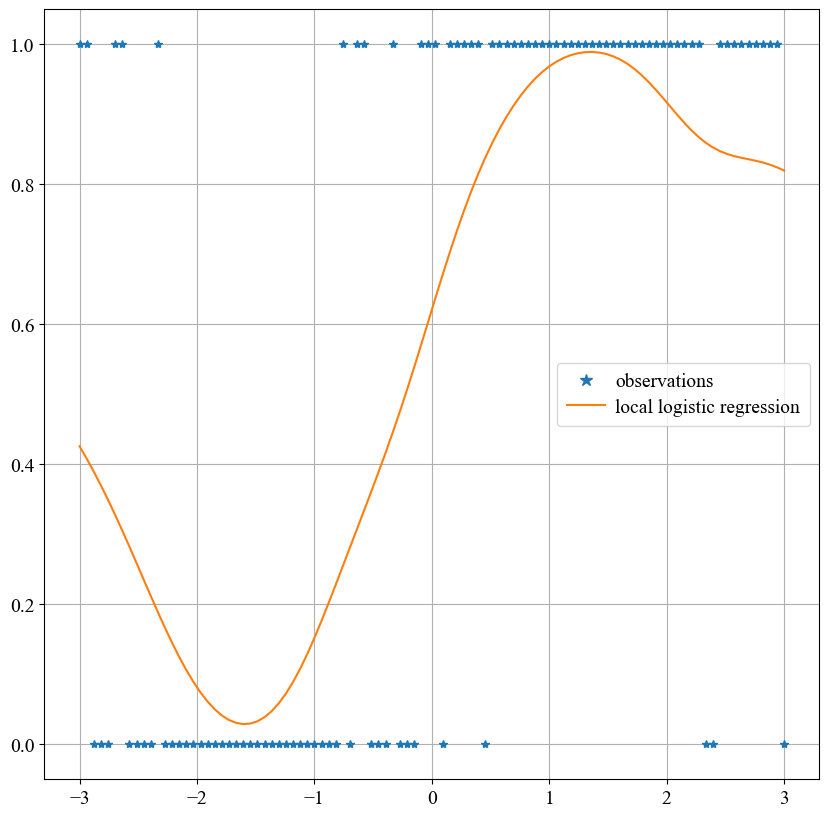

In [47]:
local_logreg = LocalLogisticRegression(bandwidth=bandwidth_opt)
local_logreg.fit(X, Y)

prediction = [local_logreg.predict_proba(value) for value in X]

plt.figure(figsize=(10, 10))
plt.plot(X, Y, "*", label="observations")
plt.plot(X, prediction, label="local logistic regression")

plt.grid()
plt.legend(fontsize=14)
plt.show()